In [258]:
import inspect
import numpy as np
import pandas as pd
import datetime
from itertools import chain, groupby
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
get_ipython().magic('matplotlib')
from  mvesc_utility_functions import *
%install_ext https://raw.github.com/cpcloud/ipython-autotime/master/autotime.py
%load_ext autotime
%matplotlib inline

absences = read_table_to_df("all_absences","clean",-1)


Using matplotlib backend: agg


/home/jgutman/env/lib/python3.4/site-packages/IPython/core/magics/extension.py:47: UserWarning: %install_ext` is deprecated, please distribute your extension as a python package.
  "as a python package.", UserWarning)


Installed autotime.py. To use it, type:
  %load_ext autotime
The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 6.93 s


In [110]:
def get_column(column_list, table, schema='clean'):
    """
    Returns a pandas dataframe with student lookup and the given list of columns

    :param list column_list: desired list of columns (student lookup automatically included)
    :rtype: pandas dataframe
    """ 
    with postgres_pgconnection_generator() as connection:
        sqlcmd = ("""select student_lookup, {cols} from {schema}."{table}";"""
            .format_map({'schema':schema,'table': table, 'cols': ', '.join(column_list)}))
        df = pd.read_sql(sqlcmd, connection)
    return df


time: 4.89 ms


8080 grads, 373 dropouts, 10439 transfers


,student_lookup,withdraw_reason


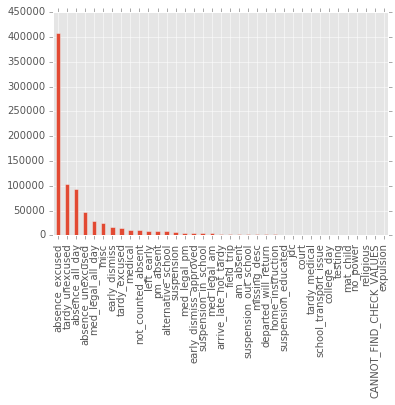

time: 1.78 s


In [348]:
absences['absence_desc'].value_counts().plot(kind='bar')

withdraw_reason = get_column(['withdraw_reason'],'wrk_tracking_students')

withdraws = withdraw_reason[pd.notnull(withdraw_reason['withdraw_reason'])]
dropouts = withdraws[withdraws['withdraw_reason'].str.contains('dropout')]
transfers = withdraws[withdraws['withdraw_reason'].str.contains('transfer')]
graduates = withdraws[withdraws['withdraw_reason'].str.contains('grad')]
print("{0} grads, {1} dropouts, {2} transfers".format(len(graduates.index), len(dropouts.index),len(transfers.index)))


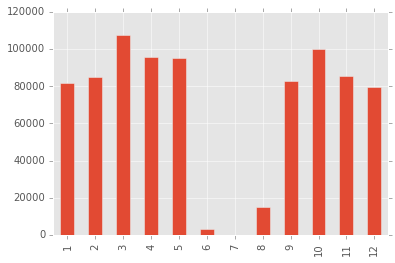

time: 471 ms


In [112]:
absences['month'].value_counts().reindex(range(1,13)).plot(kind='bar')

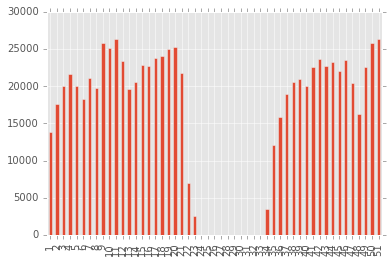

time: 1.31 s


In [113]:
absences['week'].value_counts().reindex(range(1,52)).plot(kind='bar')

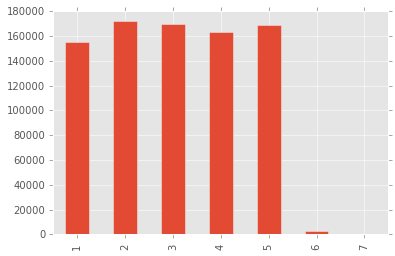

time: 431 ms


In [114]:
absences['weekday'].value_counts().reindex(range(1,8)).plot(kind='bar')

In [340]:
def all_consecutive_absences(absences, date_range=None):
    """
    Returns the all instances of multiple consecutive absences/tardies
    :param pair date_range: pair of dates, (lower_bound, upper_bound)
    :rtype: list of ints
    """
    if date_range:
        absences = absences[absences['date']>date_range[0]]
        absences = absences[absences['date']<date_range[1]]
    absent_dates = absences.sort_values(['student_lookup','date'])['date']
    delta = absent_dates[1:].reset_index()- absent_dates[:-1].reset_index()
    # not dealing with edge cases - between student blocks
    delta_list = [d.days for d in delta['date']]
    return [sum(1 for i in g)+1 for d, g in groupby(delta_list) if (d==1)] 
        

def consecutive_absences(absences, student_lookup, date_range=None):
    """
    Returns instances of multiple consecutive absences/tardies for a 
    particular student
    :param int student_lookup:
    :param pair date_range: pair of dates, (lower_bound, upper_bound)
    :rtype: list of ints
    """
    if date_range:
        temp = absences[absences['date']>date_range[0]]
        temp = temp[temp['date']<date_range[1]]
    else:
        temp = absences
    student = temp[temp['student_lookup']==student_lookup]
    student = student.sort_values('date')['date']
    delta = student[1:].reset_index()- student[:-1].reset_index()
    delta_list = [d.days for d in delta['date']]
    return [sum(1 for i in g)+1 for d, g in groupby(delta_list) if (d==1)] 

time: 34.1 ms


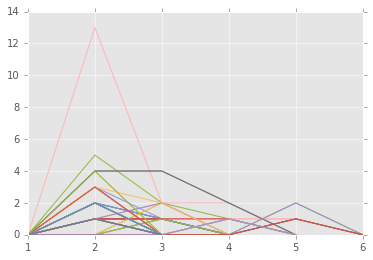

time: 18.1 s


In [341]:
unique_SL = absences.loc[~absences['student_lookup'].duplicated()]['student_lookup']
min_date = datetime.date(2015,8,1)
max_date = datetime.date(2016,6,15)
date_range = (min_date,max_date)
for s in unique_SL[:100]:
    consecutive_counts = consecutive_absences(absences,s,date_range)
    if consecutive_counts:
        [y,x] = np.histogram(consecutive_counts, range(1,max(consecutive_counts)+3))
        plt.plot(x[:-1],y)
    

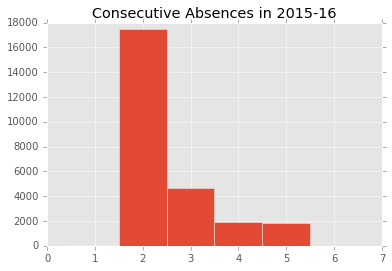

time: 929 ms


In [342]:
min_date = datetime.date(2015,8,1)
max_date = datetime.date(2016,6,15)
date_range = (min_date,max_date)
consecutive_counts = all_consecutive_absences(absences,date_range ) 
plt.hist(consecutive_counts, range(1,max(consecutive_counts)+3),align='left')
plt.title('Consecutive Absences in 2015-16')

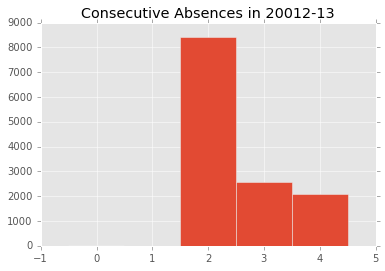

time: 839 ms


In [343]:
min_date = datetime.date(2012,8,1)
max_date = datetime.date(2013,6,15)
date_range = (min_date,max_date)
consecutive_counts = all_consecutive_absences(absences,date_range)
plt.hist(consecutive_counts, range(max(consecutive_counts)+1),align='left')
plt.title('Consecutive Absences in 20012-13')

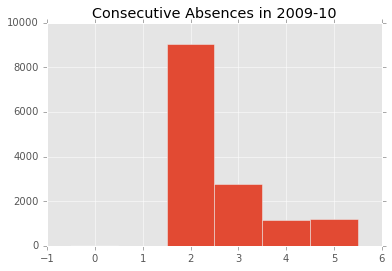

time: 887 ms


In [344]:
min_date = datetime.date(2009,8,1)
max_date = datetime.date(2010,6,15)
date_range = (min_date,max_date)
consecutive_counts = all_consecutive_absences(absences,date_range)
plt.hist(consecutive_counts, range(max(consecutive_counts)+1),align='left')
plt.title('Consecutive Absences in 2009-10')

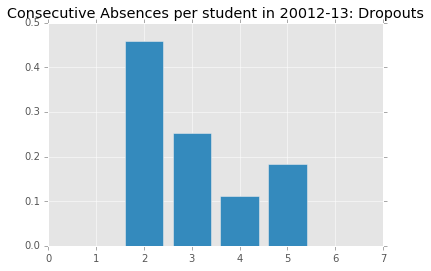

time: 494 ms


In [379]:
min_date = datetime.date(2012,8,1)
max_date = datetime.date(2013,6,15)
date_range = (min_date,max_date)
dropout_absences = absences[absences['student_lookup'].isin(dropouts['student_lookup'])]
consecutive_counts = all_consecutive_absences(dropout_absences,date_range)
[y,x] = np.histogram(consecutive_counts, range(1,max(consecutive_counts)+3))
plt.bar(x[:-1],np.divide(y,len(dropouts.index)),align='center')
plt.ylim([0,.5])
plt.title('Consecutive Absences per student in 20012-13: Dropouts')

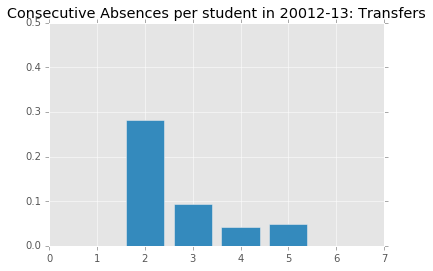

time: 732 ms


In [378]:
min_date = datetime.date(2012,8,1)
max_date = datetime.date(2013,6,15)
date_range = (min_date,max_date)
transfers_absences = absences[absences['student_lookup'].isin(transfers['student_lookup'])]
consecutive_counts = all_consecutive_absences(transfers_absences,date_range)
[y,x] = np.histogram(consecutive_counts, range(1,max(consecutive_counts)+3))
plt.bar(x[:-1],np.divide(y,len(transfers.index)),align='center')
plt.ylim([0,.5])
plt.title('Consecutive Absences per student in 20012-13: Transfers')

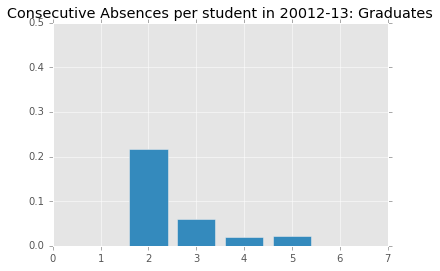

time: 1.06 s


In [377]:
min_date = datetime.date(2012,8,1)
max_date = datetime.date(2013,6,15)
date_range = (min_date,max_date)
grads_absences = absences[absences['student_lookup'].isin(graduates['student_lookup'])]
consecutive_counts = all_consecutive_absences(grads_absences,date_range)
[y_grad,x_grad] = np.histogram(consecutive_counts, range(1,max(consecutive_counts)+3))
fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(x_grad[:-1],np.divide(y_grad,len(graduates.index)),align='center')
plt.ylim([0,.5])
plt.title('Consecutive Absences per student in 20012-13: Graduates')